<a href="https://colab.research.google.com/github/amwatts86/RE_Linear_Regression/blob/main/RE_Regression%20v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing Required Modules**


In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

**Importing Required Data**


In [73]:
train_data = pd.read_csv("sample_data/train.csv")
test_data = pd.read_csv("sample_data/test.csv")
test_data_submission = pd.read_csv("sample_data/test.csv")

**Selecting Features**

In [74]:
# table of descriptive statistics for each feature
train_data.describe(include='all')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
count,1460.000000,1460.000000,1460,1201.000000,1460.000000,1460,91,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460.000000,1460.000000,1460.000000,1460.000000,1460,1460,1460,1460,1452,1452.000000,1460,1460,1460,1423,1423,1422,1423,1460.000000,1422,1460.000000,1460.000000,1460.000000,1460,...,1460,1459,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460,1460.000000,1460,1460.000000,770,1379,1379.000000,1379,1460.000000,1460.000000,1379,1379,1460,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,7,281,54,1460.000000,1460.000000,1460.000000,1460,1460,1460.000000
unique,NaN,NaN,5,NaN,NaN,2,2,4,4,2,5,3,25,9,8,5,8,NaN,NaN,NaN,NaN,6,8,15,16,4,NaN,4,5,6,4,4,4,6,NaN,6,NaN,NaN,NaN,6,...,2,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN,7,NaN,5,6,NaN,3,NaN,NaN,5,5,3,NaN,NaN,NaN,NaN,NaN,NaN,3,4,4,NaN,NaN,NaN,9,6,NaN
top,NaN,NaN,RL,NaN,NaN,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,NaN,NaN,NaN,NaN,Gable,CompShg,VinylSd,VinylSd,None,NaN,TA,TA,PConc,TA,TA,No,Unf,NaN,Unf,NaN,NaN,NaN,GasA,...,Y,SBrkr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TA,NaN,Typ,NaN,Gd,Attchd,NaN,Unf,NaN,NaN,TA,TA,Y,NaN,NaN,NaN,NaN,NaN,NaN,Gd,MnPrv,Shed,NaN,NaN,NaN,WD,Normal,NaN
freq,NaN,NaN,1151,NaN,NaN,1454,50,925,1311,1459,1052,1382,225,1260,1445,1220,726,NaN,NaN,NaN,NaN,1141,1434,515,504,864,NaN,906,1282,647,649,1311,953,430,NaN,1256,NaN,NaN,NaN,1428,...,1365,1334,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,735,NaN,1360,NaN,380,870,NaN,605,NaN,NaN,1311,1326,1340,NaN,NaN,NaN,NaN,NaN,NaN,3,157,49,NaN,NaN,NaN,1267,1198,NaN
mean,730.500000,56.897260,NaN,70.049958,10516.828082,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.099315,5.575342,1971.267808,1984.865753,NaN,NaN,NaN,NaN,NaN,103.685262,NaN,NaN,NaN,NaN,NaN,NaN,NaN,443.639726,NaN,46.549315,567.240411,1057.429452,NaN,...,NaN,NaN,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,NaN,6.517808,NaN,0.613014,NaN,NaN,1978.506164,NaN,1.767123,472.980137,NaN,NaN,NaN,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,NaN,NaN,NaN,43.489041,6.321918,2007.815753,NaN,NaN,180921.195890
std,421.610009,42.300571,NaN,24.284752,9981.264932,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.382997,1.112799,30.202904,20.645407,NaN,NaN,NaN,NaN,NaN,181.066207,NaN,NaN,NaN,NaN,NaN,NaN,NaN,456.098091,NaN,161.319273,441.866955,438.705324,NaN,...,NaN,NaN,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,NaN,1.625393,NaN,0.644666,NaN,NaN,24.689725,NaN,0.747315,213.804841,NaN,NaN,NaN,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,NaN,NaN,NaN,496.123024,2.703626,1.328095,NaN,NaN,79442.502883
min,1.000000,20.000000,NaN,21.000000,1300.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1872.000000,1950.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000,NaN,...,NaN,NaN,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,2.000000,NaN,0.000000,NaN,NaN,1900.000000,NaN,0.0

In [75]:
# remove features that have over 20% null values
null_items = train_data.isnull().sum().sort_values(ascending=False)
null_index = null_items[null_items > train_data.shape[0]*0.20].index
train_data.drop(columns=null_index, inplace=True)
test_data.drop(columns=null_index, inplace=True)

In [76]:
# numerical null checking
num_variables = train_data[train_data.dtypes[train_data.dtypes != 'object'].index]
num_var_null = num_variables.isnull().sum()
num_index_null = num_var_null[num_var_null > 0].index
num_index_null

Index(['LotFrontage', 'MasVnrArea', 'GarageYrBlt'], dtype='object')

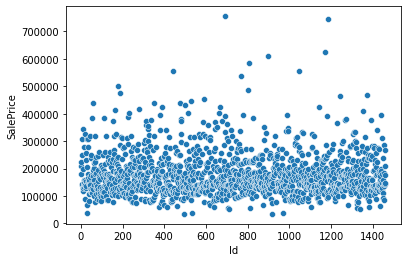

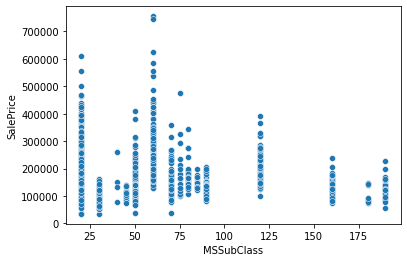

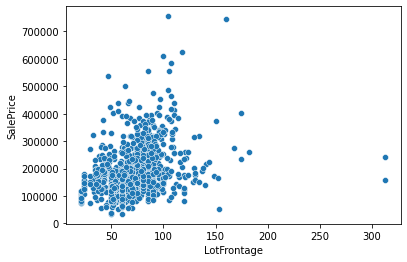

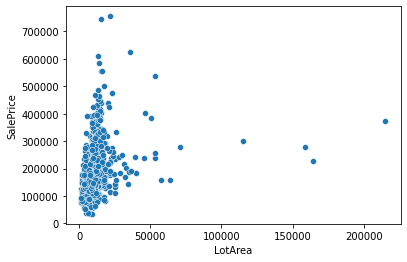

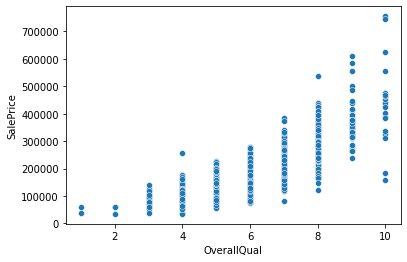

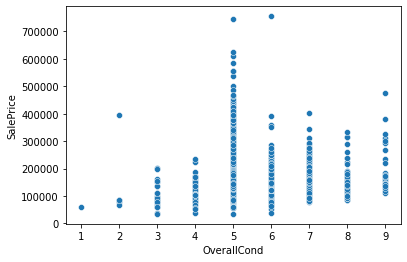

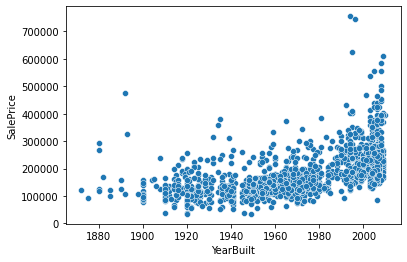

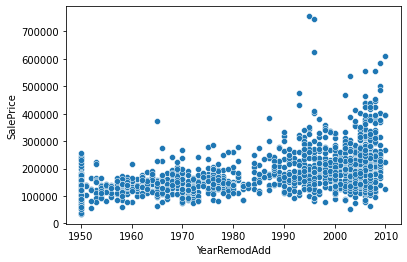

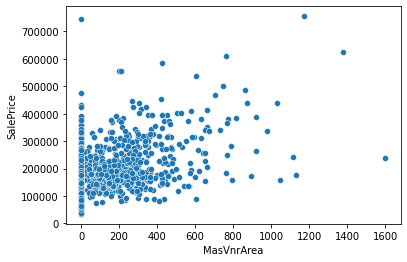

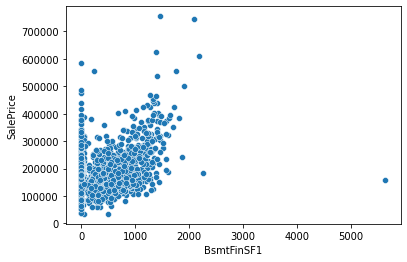

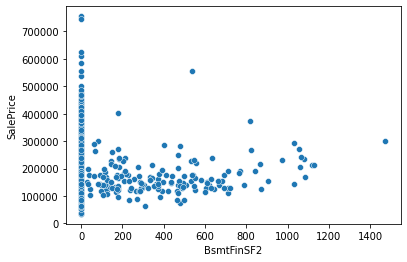

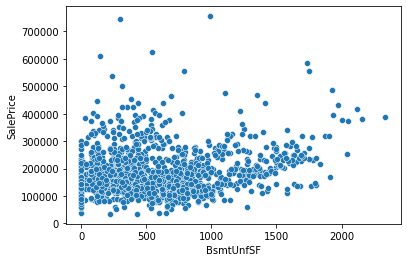

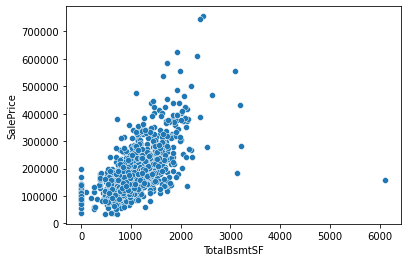

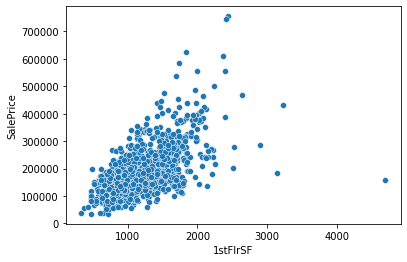

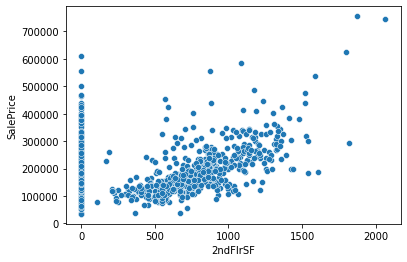

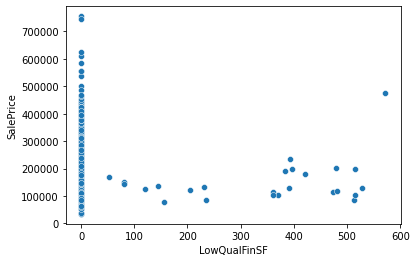

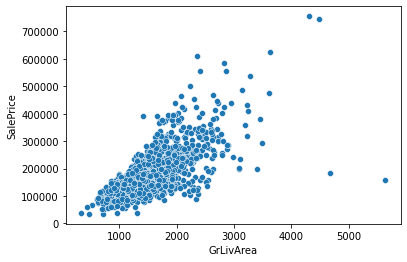

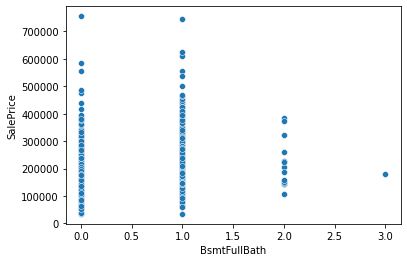

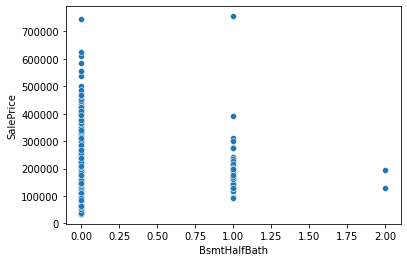

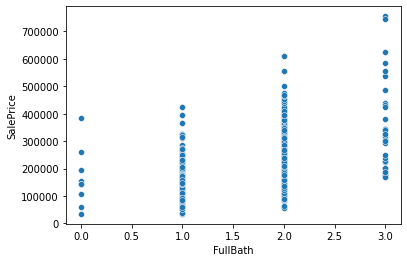

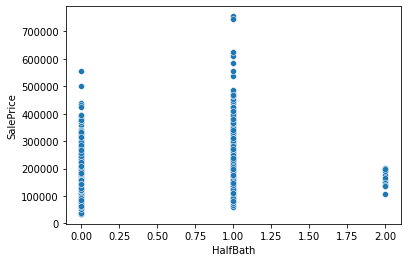

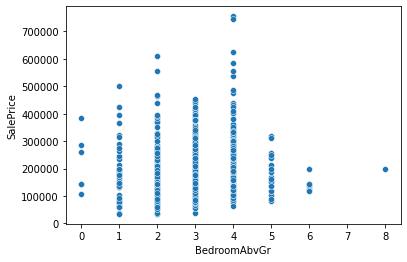

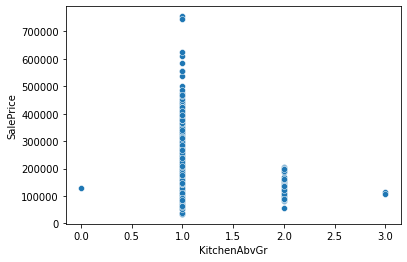

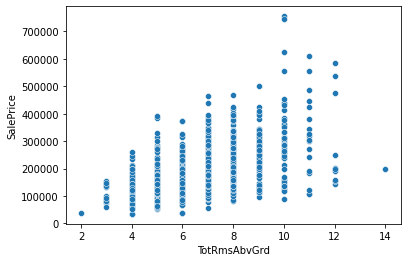

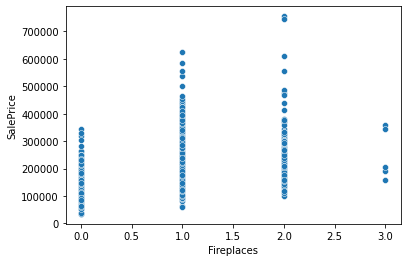

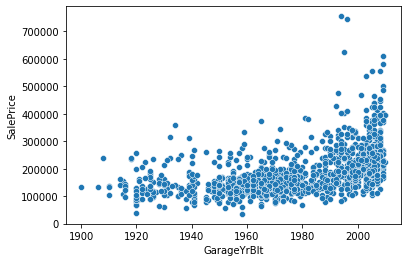

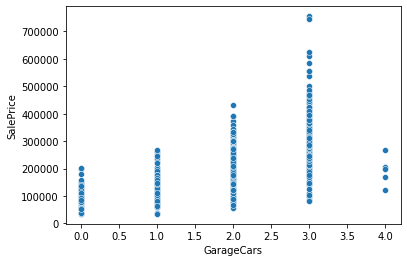

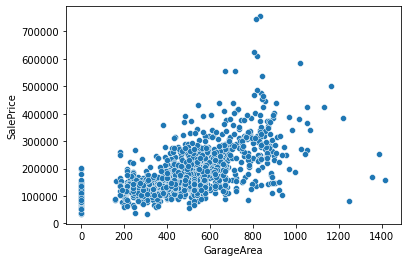

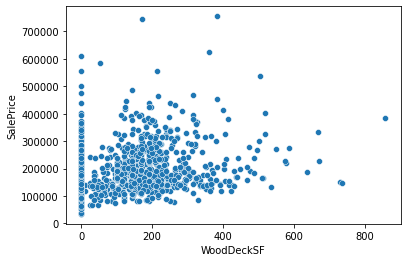

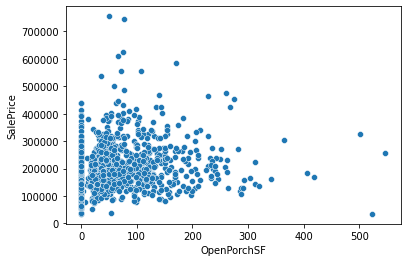

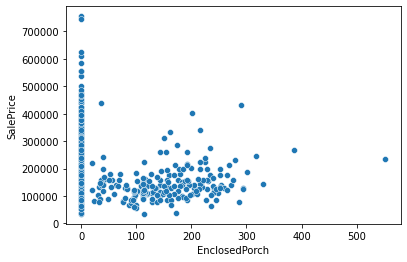

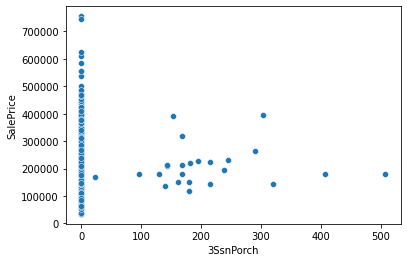

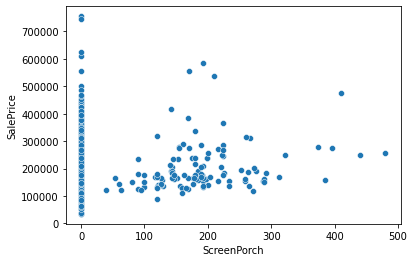

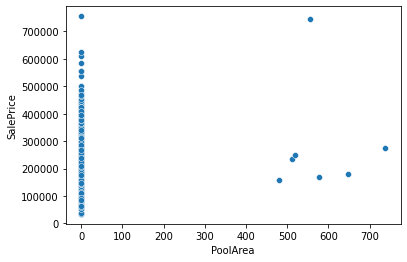

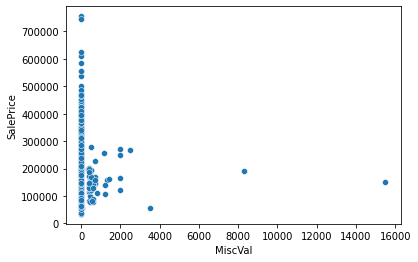

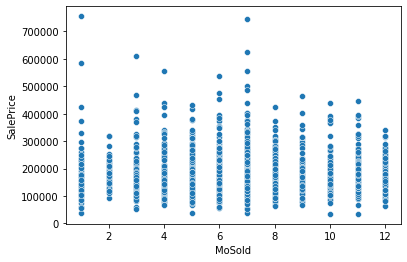

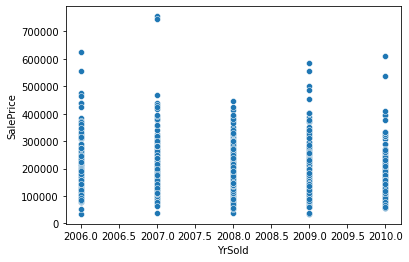

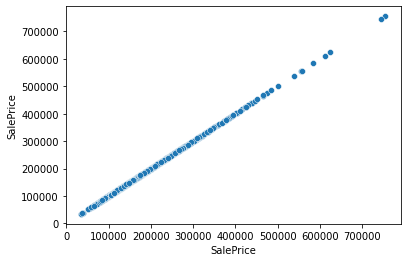

In [77]:
# plot numerical features against SalePrice
for col in num_variables:
  sns.scatterplot(data = num_variables, x = col, y = 'SalePrice')
  plt.show()

In [78]:
# remove non-material columns
insig_cols = ['Id', 'MSSubClass', 'BsmtFinSF2', 'LowQualFinSF', 
              'BsmtFullBath', 'BsmtHalfBath', 'HalfBath', 
              'BedroomAbvGr', 'KitchenAbvGr', 'Fireplaces',
              'GarageYrBlt', 'EnclosedPorch', '3SsnPorch',
              'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold',
              'YrSold', '1stFlrSF', 'GarageArea', 'GarageYrBlt',
              '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']
train_data.drop(columns=insig_cols, inplace=True)
test_data.drop(columns=insig_cols, inplace=True)

In [79]:
# drop outliers (spotting by eye)
train_data = train_data[train_data['GrLivArea'] < 4500]
train_data = train_data[train_data['WoodDeckSF'] < 500]
train_data = train_data[train_data['OpenPorchSF'] < 300]
train_data = train_data[train_data['LotFrontage'] < 200]
train_data = train_data[train_data['LotArea'] < 100000]
train_data = train_data[train_data['MasVnrArea'] < 850]
train_data = train_data[train_data['BsmtFinSF1'] < 2000]
train_data = train_data[train_data['TotalBsmtSF'] < 3000]

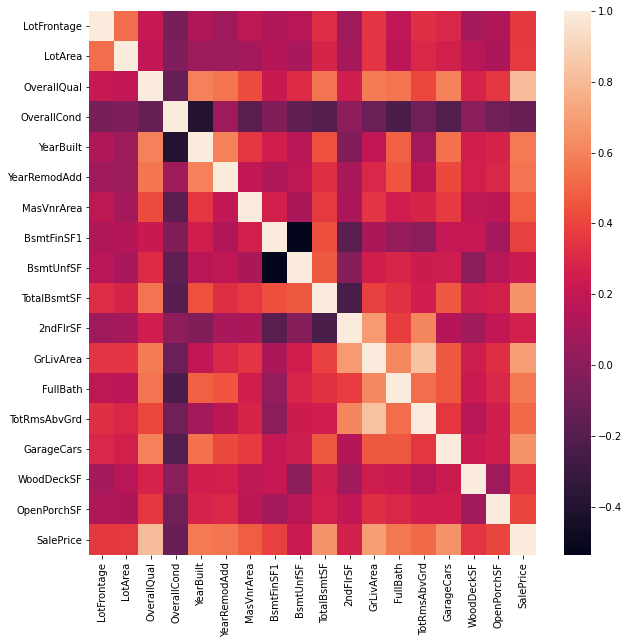

In [80]:
# observe correlations
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(train_data.corr(), ax=ax)

In [81]:
# set features and target variables
y = train_data['SalePrice']
x = train_data.drop(columns=['SalePrice'])

In [82]:
# seperate categorical and numerical variables
cat_vars = x[x.dtypes[train_data.dtypes == 'object'].index]
num_vars = x[x.dtypes[x.dtypes != 'object'].index]

In [83]:
cat_vars

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
0,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
1,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
2,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
3,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,None,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,Detchd,Unf,TA,TA,Y,WD,Abnorml
4,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,FV,Pave,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
1455,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,Gd,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
1456,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,Plywood,Plywood,Stone,TA,TA,CBlock,Gd,TA,No,ALQ,Rec,GasA,TA,Y,SBrkr,TA,Min1,Attchd,Unf,TA,TA,Y,WD,Normal
1457,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,CemntBd,CmentBd,None,Ex,Gd,Stone,TA,Gd,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal



**Data Preprocessing**

In [84]:
# import required modules to encode, scale, impute and train
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.impute import SimpleImputer

In [85]:
# create a pipeline object for numerical data to impute missings 
# with the mean and standard scaler to scale down the data
num_transformer = Pipeline(
    [
     ('impute', SimpleImputer(strategy='mean')),
     ('scaler', StandardScaler())
    ]
)

In [86]:
# create a pipeline object for categorical data to impute missings
# with the most frequent value and one hot encoder to create columns
# for each category
cat_transformer = Pipeline(
    [('impute', SimpleImputer(strategy='most_frequent')),
     ('onehot', OneHotEncoder(handle_unknown = 'ignore'))
     ]
)

In [87]:
# create a preprocess object composed of both the transformers
# above
preprocess = ColumnTransformer(
    [
     ('num_transform', num_transformer, num_vars.columns),
     ('cat_transform', cat_transformer, cat_vars.columns)
    ]
)

**Fit Linear Regression Model** 

In [88]:
# combine transforms and model into new pipeline object
pipeline = Pipeline(
    [('preprocessor', preprocess),
     ('model', LinearRegression())
    ]
)

In [89]:
# create train and test sets
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=30)

In [90]:
# fit model and generate predictions
pipeline.fit(train_x, train_y)
predictions = pipeline.predict(test_x)

# generate MAE and cross val score (mean of 5)
error_MAE = mean_absolute_error(test_y, predictions)
cv_score = cross_val_score(pipeline, x, y, cv=5).mean()
print(f"MAE: {error_MAE}, Cross Val. Score: {cv_score}")

MAE: 16431.98713254296, Cross Val. Score: 0.8953201396239502


**Fit Linear Regression Model** 

In [91]:
predictions = pipeline.predict(test_data)
predictions

array([109788.12634052, 173331.41677279, 187694.67130067, ...,
       179631.04491888, 112451.01834306, 208439.69882224])

In [92]:
new_sub = pd.DataFrame({'Id': test_data_submission['Id'], 'SalePrice': predictions})
new_sub

,Id,SalePrice
0,1461,109788.126341
1,1462,173331.416773
2,1463,187694.671301
3,1464,192950.912012
4,1465,210053.044989
...,...,...
1454,2915,77461.142790
1455,2916,81192.481179
1456,2917,179631.044919
1457,2918,112451.018343
